# Cancer Classification for Genomic Data
The main file for testing of classification models.

## Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

# import preprocessors
from data.preprocess_data import RawData, MinMaxScaledData, StandardScaledData
# import third party various libraries
import numpy as np
import pandas as pd
from typing import Literal # dan and his typing
from collections import defaultdict
# small army of sklearn imports
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import RFECV, VarianceThreshold, SelectKBest, f_classif
# import specific models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
# stop warning me
import warnings
warnings.filterwarnings("ignore")

The `get_gene_id` translates the dummy ID from the dataset to the real gene name

In [50]:
def get_gene(index):
    # csv file made from original data source file unc.edu_PANCAN_IlluminaGA_RNASeqV2.geneExp.tsv at https://www.synapse.org/#!Synapse:syn4301332
    df = pd.read_csv('gene_ids.csv') 
    result = df.loc[df['dummy_id'] == index]
    return result['gene_id'].values[0]

index = 3523
gene = get_gene(index = index)
print(f'The gene with index {index}: {gene}')

The gene with index 3523: CDX1|1044


The `fit_and_val_classifier` function is a general function for testing an `sklearn` classifier on the preprocessed dataset. 

In [2]:
from time import time

raw_data = RawData()
X_train, y_train, X_val, y_val, X_test, y_test = raw_data.get_data()

def fit_and_val_sklearn_classifier(classifier, X_train=X_train, X_val=X_val, verbose=False):
    start = time()
    classifier.fit(X_train, y_train)
    if verbose: print(f'Classifier fit in {(time()-start):.3f}s')
    y_pred_val = classifier.predict(X_val)
    val_acc = accuracy_score(y_true=y_val, y_pred=y_pred_val)
    if verbose: 
        print(f'Validation accuracy: {(val_acc*100):.3f}%\nClassification Report (Validation):\n{classification_report(y_val, y_pred_val)}')
    return val_acc

## Summary Table of Results
*Note that the below cell may take a while to run, as it fits a large number of models*

We next generate a summary of how different models, hyperparameters, and preprocessing methods affect the validation accuracy. We use this table to decide that the best combination for modeling is TODO. In general, we see high performance accross many types of tree-based and linear models. 

The rest of the file shows specifics for different models and  data-preprocessing methods. 

In [3]:

def make_val_summary_table(models_lst, preprocessed_data_lst):
    df_dict = {'Models':[]}
    for index, data_obj in enumerate(preprocessed_data_lst):
        data_source = data_obj.get_data()
        # ds_name = data_source.name
        ds_name = data_obj.name
        df_dict[ds_name] = []
        for model in models_lst:
            if index == 0: df_dict['Models'].append(str(model))
            val_acc = fit_and_val_sklearn_classifier(
                classifier=model,
                X_train=data_source[0],
                X_val=data_source[2],
            )
            df_dict[ds_name].append(val_acc*100)
    df = pd.DataFrame(df_dict)
    return df

rand_state = 42 # 
summary_table = make_val_summary_table(
    models_lst = [
        DecisionTreeClassifier(random_state=rand_state),
        RandomForestClassifier(random_state=rand_state),
        AdaBoostClassifier(n_estimators=10, random_state=rand_state),
        GradientBoostingClassifier(n_estimators=5, random_state=rand_state),
        LogisticRegression(random_state=rand_state),
    ],
    preprocessed_data_lst = [
        RawData(),
        MinMaxScaledData(),
        StandardScaledData(),
    ]
)

pd.set_option('display.precision', 2) # set the precision of the accuracy in the table
summary_table

,Models,Raw Data,MinMax Scaled Data,Standard Scaled Data
0,DecisionTreeClassifier(random_state=42),96.88,96.88,96.88
1,RandomForestClassifier(random_state=42),100.00,100.00,100.00
2,"AdaBoostClassifier(n_estimators=10, random_sta...",80.62,80.62,80.62
3,"GradientBoostingClassifier(n_estimators=5, ran...",98.75,98.75,98.75
4,LogisticRegression(random_state=42),100.00,100.00,100.00


## Shapley Values - Nicole

In [4]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

print('--- Random Forest ---')
val_acc = fit_and_val_sklearn_classifier(classifier=model, verbose=True)

--- Random Forest ---
Classifier fit in 1.470s
Validation accuracy: 100.000%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        61
        COAD       1.00      1.00      1.00        19
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      1.00      1.00        19
        PRAD       1.00      1.00      1.00        31

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



TODO explain

In [5]:
import shap

def shapley_value_reduce(model, k=1000):
    # Calculate Shapley values
    explainer = shap.TreeExplainer(model)  
    shap_values = explainer.shap_values(X_train)

    # mean absolute Shapley value for each feature 
    shap_values_mean = np.abs(shap_values).mean(axis=0)  

    top_k_features = np.argsort(shap_values_mean)[-k:]  
    selected_features = X_train.columns[top_k_features.flatten()]

    X_train_reduced = X_train[selected_features]
    X_val_reduced = X_val[selected_features] 
    X_test_reduced = X_test[selected_features]

    return X_train_reduced, X_val_reduced, X_test_reduced

# model from previous cell
X_train_reduced, X_val_reduced, X_test_reduced = shapley_value_reduce(model)

model_reduced = RandomForestClassifier(n_estimators=100, random_state=42)

val_acc = fit_and_val_sklearn_classifier(
    classifier = model_reduced,
    X_train = X_train_reduced,
    X_val = X_val_reduced,
    verbose=True
)


Classifier fit in 1.091s
Validation accuracy: 56.250%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       0.64      0.64      0.64        61
        COAD       0.75      0.63      0.69        19
        KIRC       0.75      0.70      0.72        30
        LUAD       0.20      0.16      0.18        19
        PRAD       0.38      0.48      0.42        31

    accuracy                           0.56       160
   macro avg       0.54      0.52      0.53       160
weighted avg       0.57      0.56      0.56       160



TODO explain

## Random Forest w/ ANOVA - Nicole
TODO explain

In [6]:
def filter_by_feature_performance(X_train, X_val, X_test, y_train, y_val, y_test):
    y_train = y_train.values.ravel() if hasattr(y_train, 'values') else y_train.ravel()
    y_val = y_val.values.ravel() if hasattr(y_val, 'values') else y_val.ravel()
    y_test = y_test.values.ravel() if hasattr(y_test, 'values') else y_test.ravel()

    variance_selector = VarianceThreshold(threshold=0.01)
    X_train_var = variance_selector.fit_transform(X_train)
    X_val_var = variance_selector.transform(X_val)
    X_test_var = variance_selector.transform(X_test)

    k_best_selector = SelectKBest(f_classif, k=5000)
    X_train_kbest = k_best_selector.fit_transform(X_train_var, y_train)
    X_val_kbest = k_best_selector.transform(X_val_var)
    X_test_kbest = k_best_selector.transform(X_test_var)

    base_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    base_model.fit(X_train_kbest, y_train)

    importances = base_model.feature_importances_
    top_indices = np.argsort(importances)[-1000:]

    X_train_final = X_train_kbest[:, top_indices]
    X_val_final = X_val_kbest[:, top_indices]
    X_test_final = X_test_kbest[:, top_indices]
    
    return X_train_final, X_val_final, X_test_final

X_train_final, X_val_final, X_test_final = filter_by_feature_performance(
    X_train, X_val, X_test, y_train, y_val, y_test
)

final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

fit_and_val_sklearn_classifier(
    classifier=final_model,
    X_train=X_train_final,
    X_val=X_val_final,
    verbose=True
)

y_pred_test = final_model.predict(X_test_final)
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Classification Report (Test):\n", classification_report(y_test, y_pred_test))


Classifier fit in 0.094s
Validation accuracy: 100.000%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        61
        COAD       1.00      1.00      1.00        19
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      1.00      1.00        19
        PRAD       1.00      1.00      1.00        31

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

Test Accuracy: 0.9937888198757764
Classification Report (Test):
               precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        62
        COAD       1.00      1.00      1.00        15
        KIRC       1.00      0.97      0.98        30
        LUAD       1.00      1.00      1.00        32
        PRAD       1.00      1.00      1.00        22

    accuracy                 

TODO interpretation

## Log Regression - Hanna
TODO explain

In [7]:
from sklearn.preprocessing import StandardScaler

#initialize logistic regression model, configured for multinomial classificaiton (>2 classes), using 'lbfgs' solver
#the 'max_iter' parameter ensures sufficient iterations for convergence, and 'random_state' ensures reproducibility
#https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

print(f'--- Logistic Regression ---')
val_acc = fit_and_val_sklearn_classifier(classifier=log_reg, verbose=True)


--- Logistic Regression ---
Classifier fit in 0.999s
Validation accuracy: 100.000%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        61
        COAD       1.00      1.00      1.00        19
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      1.00      1.00        19
        PRAD       1.00      1.00      1.00        31

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160



TODO explain

## K-Means with PCA - Hanna
TODO explain

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.optimize import linear_sum_assignment

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import GridSearchCV

import seaborn as sns


# #load data; load the feature data and labels from Parquet files into Pandas DataFrames
# #the 'data.parquet' file contains the features, while 'labels.parquet' contains the target class labels
# #https://pandas.pydata.org/docs/reference/api/pandas.read_parquet.html
# data = pd.read_parquet('data.parquet')
# labels = pd.read_parquet('labels.parquet')

# #map the labels to an encoding dicitonary to ensure consistent class mapping
# labels['Class'] = labels['Class'].map(encoding_dict)

# #rename columns for readability and usability
# #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
# data.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)
# labels.rename(columns={'Unnamed: 0': 'sample_id'}, inplace=True)


# #merge datasets; combine the features and labels intoa single DataFrame, joining on the common column 'sample_id'
# #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
# merged_data = pd.merge(data, labels, on='sample_id')

# #drop the sample_id column as it isn't needed for analaysis
# #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
# #features
# data = merged_data.drop(columns=['sample_id', 'Class'])
# #labels
# labels = merged_data['Class']

# #standardize features with StandardScalar to normalize values, ensuring each feature has a mean of 0 and
# # a standard deviation of 1
# #https://scikit-learn.org/dev/modules/generated/sklearn.preprocessing.StandardScaler.html
# scaler = StandardScaler()
# #fit and transform the training data
# data_scaled = scaler.fit_transform(data)


X_train, y_train, X_val, y_val, X_test, y_test = StandardScaledData().get_data()


#Grid Search CV: https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/
def pca_grid_search(data, components_range):
    results = {}
    for n in components_range:
        pca = PCA(n_components=n, random_state=42)
        reduced_data = pca.fit_transform(data)
        variance_explained = sum(pca.explained_variance_ratio_)
        results[n] = variance_explained
    return results

#perform PCA grid search
#components_range = rcomponents_range = range(200, min(data_scaled.shape[1], 801), 50) # Include up to 801 or total features - 2 minutes and 6.4 seconds
max_components = min(500, X_train.shape[1]) # Limit to 500 components or feature count
components_range = range(50, max_components, 50) # Start from 50 with a step of 50
variance_results = pca_grid_search(data=X_train, components_range=components_range)

#find the optimal number of components (e.g., retain ~95% variance)
optimal_components = max(k for k, v in variance_results.items() if v >= 0.85)

#apply PCA for dimensionality reduction: reduce the feature set to 20 principlal components to simplify the dataset
# while retraining as much variance as possible
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components=optimal_components, random_state=42)
data_reduced = pca.fit_transform(X_train)

X_train_reduced = pca.fit_transform(X_train)
X_val_reduced = pca.transform(X_val)
X_test_reduced = pca.transform(X_test)

labels = y_train # TODO remove 
encoding_dict = {
    'BRCA': 0,
    'KIRC': 1,
    'COAD': 2,
    'LUAD': 3,
    'PRAD': 4
}
labels['Class'] = labels['Class'].map(encoding_dict)



#apply k-means clustering
#https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html
#define the number of clustesr
clusters = len(np.unique(labels))
#apply kmeans
k_means = KMeans(n_clusters=clusters, random_state=42, init='k-means++')
#fit the scaled down data

# k_means.fit(data_reduced)
# y_kmeans = k_means.predict(data_reduced)

k_means.fit(X_train_reduced)
y_kmeans = k_means.predict(X_train_reduced)

#get clusters and centroids
cluster_labels = k_means.labels_
centroids = k_means.cluster_centers_

# #compute the contingency matrix
# #https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.cluster.contingency_matrix.html
# cont_matrix = contingency_matrix(labels, cluster_labels)

# #match each cluster to the true label with the highest count
# cluster_label_match = np.argmax(cont_matrix, axis=1)

# #map predicted cluster labels to the corresponding true labels
# mapped_cluster_labels = np.array([cluster_label_match[label] for label in cluster_labels])



#compute the contingency matrix
cont_matrix = contingency_matrix(labels, cluster_labels)

#solve the optimal alignment problem
row_ind, col_ind = linear_sum_assignment(-cont_matrix) # Negative for maximization

#map cluster labels to ground truth labels
mapped_cluster_labels = np.zeros_like(cluster_labels)
for i, j in zip(row_ind, col_ind):
    mapped_cluster_labels[cluster_labels == j] = i

#accuracy and classificaition report
accuracy= accuracy_score(labels, mapped_cluster_labels)
# print(labels) TODO remove
# print('------')
# print(mapped_cluster_labels)
classification_r = classification_report(labels, mapped_cluster_labels)

print("K-Means Report")
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report (Test):\n", classification_r)

#silhouette score with euclidean metric
# silhouette_s = silhouette_score(X=data_scaled, labels=cluster_labels, metric='euclidean')
# print(f"Silhouette Score: {silhouette_s:.2f}")

#2d visualization using PCA (reduce to 2 dimensions for plotting)
plt.figure(figsize=(10, 8))
# sns.scatterplot(x=data_reduced[:, 0], y=data_reduced[:, 1], hue=mapped_cluster_labels, palette='viridis', s=50, alpha=0.8)
sns.scatterplot(x=X_train_reduced[:, 0], y=X_train_reduced[:, 1], hue=mapped_cluster_labels, palette='viridis', s=50, alpha=0.8)
# plt.scatter(k_means.cluster_centers_[:, 0], k_means.cluster_centers_[:, 1], c='red', s=200, alpha=0.8, label="Centroids")
# plt.title("KMeans Clusters with PCA")
plt.title("Principal Component Analysis")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")
plt.show()


## Decision Trees, AdaBoost & Gradient Boosting - Jack & Dan
We next test the boosting algorithms Gradient Boosting and AdaBoost. We conduct a small hyperparameter search over the number of estimators `n_estimators` trained by these ensemble methods.

In [9]:
dtree = DecisionTreeClassifier()

adaboost = AdaBoostClassifier(n_estimators=10)

gradboost = GradientBoostingClassifier(n_estimators=5)

rforest = RandomForestClassifier(n_estimators=100, random_state=42)

print('--- Decision Tree ---')
val_acc = fit_and_val_sklearn_classifier(classifier=dtree, verbose=True)

print('--- AdaBoost ---')
val_acc = fit_and_val_sklearn_classifier(classifier=adaboost, verbose=True)

print('--- Gradient Boosting ---')
val_acc = fit_and_val_sklearn_classifier(classifier=gradboost, verbose=True)




--- Decision Tree ---
Classifier fit in 2.219s
Validation accuracy: 96.875%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       0.98      0.98      0.98        61
        COAD       0.90      0.95      0.92        19
        KIRC       0.97      1.00      0.98        30
        LUAD       0.94      0.89      0.92        19
        PRAD       1.00      0.97      0.98        31

    accuracy                           0.97       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.97      0.97      0.97       160

--- AdaBoost ---
Classifier fit in 8.307s
Validation accuracy: 80.625%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       1.00      0.98      0.99        61
        COAD       1.00      1.00      1.00        19
        KIRC       0.00      0.00      0.00        30
        LUAD       0.38      1.00      0.55        19
        PRAD       1.

In terms of performance, both the Gradient Boosting and AdaBoost classifiers achieve >99% validation accuracy and >94% test accuracy on the dataset, though there are some differences in the models. Gradient Boosting achieves this performance reliably, but training is an order of magnitude slower. In contrast, AdaBoost is less reliable, but trains significantly faster even with a larger number of estimators. 

## SVM - Hanna

In [10]:
from sklearn.svm import SVC

#initalize the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)

print("Support Vector Machine")
#evaluate the svm model
val_acc = fit_and_val_sklearn_classifier(classifier=svm_model, verbose=True)

#test the model on the test set
svm_model.fit(X_train, y_train)
y_pred_test = svm_model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred_test))
print("Classification Report (Test): \n", classification_report(y_test, y_pred_test))

Support Vector Machine
Classifier fit in 1.427s
Validation accuracy: 100.000%
Classification Report (Validation):
              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        61
        COAD       1.00      1.00      1.00        19
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      1.00      1.00        19
        PRAD       1.00      1.00      1.00        31

    accuracy                           1.00       160
   macro avg       1.00      1.00      1.00       160
weighted avg       1.00      1.00      1.00       160

Test Accuracy:  0.9937888198757764
Classification Report (Test): 
               precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99        62
        COAD       1.00      1.00      1.00        15
        KIRC       1.00      0.97      0.98        30
        LUAD       1.00      1.00      1.00        32
        PRAD       1.00      1.00      1.00        22

    

## Feature Importance

In [24]:
raw_data = RawData()
X_train, y_train, X_val, y_val, X_test, y_test = raw_data.get_data()

X_train

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
257,0.0,4.40,4.15,6.80,9.30,0.0,7.72,0.31,0.0,0.0,...,6.64,9.10,10.38,6.02,10.22,11.02,10.79,10.22,4.35,0.31
766,0.0,3.35,3.51,7.93,9.28,0.0,7.54,0.76,0.0,0.0,...,5.87,9.48,10.42,0.43,9.38,11.54,10.78,9.58,4.95,0.00
544,0.0,2.65,2.26,6.29,10.13,0.0,7.98,0.76,0.0,0.0,...,6.40,8.82,10.21,7.61,10.00,11.22,9.83,10.40,5.96,0.00
15,0.0,2.90,3.69,6.67,10.00,0.0,6.95,0.00,0.0,0.0,...,6.35,9.23,9.98,5.25,9.69,12.07,9.97,9.84,9.05,0.00
3,0.0,3.66,4.51,6.66,10.20,0.0,7.84,0.43,0.0,0.0,...,6.08,8.79,10.14,8.94,9.60,11.39,9.69,9.68,3.29,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.0,1.02,2.53,5.83,9.96,0.0,7.84,0.00,0.0,0.0,...,5.54,8.51,9.80,6.12,9.34,12.12,9.80,9.36,5.49,0.00
106,0.0,1.23,1.88,5.71,10.03,0.0,7.18,0.45,0.0,0.0,...,5.07,8.50,9.94,2.92,9.51,12.36,9.98,9.54,2.78,0.00
270,0.0,2.53,2.62,6.35,9.01,0.0,9.86,1.45,0.0,0.0,...,6.19,8.21,10.60,5.08,9.82,11.73,10.35,9.28,4.19,0.00
435,0.0,4.13,3.72,6.14,9.64,0.0,7.99,1.68,0.0,0.0,...,7.49,9.15,10.09,0.80,10.31,12.17,10.98,10.02,6.39,0.00


In [25]:
feature_names = X_train.columns.tolist()

In [26]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

variance_selector = VarianceThreshold(threshold=0.0)
X_train = variance_selector.fit_transform(X_train)
X_val = variance_selector.transform(X_val)
X_test = variance_selector.transform(X_test)

feature_names = [feature_names[i] for i in variance_selector.get_support(indices=True)]

k = 1000
anova_selector = SelectKBest(f_classif, k=min(k, len(feature_names)))
X_train_kbest = anova_selector.fit_transform(X_train, y_train)

f_scores = anova_selector.scores_
p_values = anova_selector.pvalues_

if np.isnan(f_scores).any():
    print("NaN detected in F-scores. Removing invalid features.")
    valid_indices = ~np.isnan(f_scores)
    f_scores = f_scores[valid_indices]
    p_values = p_values[valid_indices]
    feature_names = [feature_names[i] for i in valid_indices]

sorted_indices = np.argsort(f_scores)[::-1]
sorted_f_scores = f_scores[sorted_indices]
sorted_p_values = p_values[sorted_indices]

top_features = [feature_names[i] for i in sorted_indices[:k]]

print("\nTop 25 Features by ANOVA F-Score:")
for i in range(25):
    print(f"Feature: {top_features[i]}, F-score: {sorted_f_scores[i]:.2f}, p-value: {sorted_p_values[i]:.5e}")



Top 25 Features by ANOVA F-Score:
Feature: gene_9175, F-score: 2808.22, p-value: 0.00000e+00
Feature: gene_9176, F-score: 2379.21, p-value: 1.42980e-312
Feature: gene_219, F-score: 2220.93, p-value: 8.05029e-306
Feature: gene_220, F-score: 2198.52, p-value: 7.91089e-305
Feature: gene_18135, F-score: 1573.44, p-value: 2.06439e-272
Feature: gene_450, F-score: 1510.44, p-value: 1.68539e-268
Feature: gene_14114, F-score: 1492.37, p-value: 2.38317e-267
Feature: gene_13818, F-score: 1369.39, p-value: 3.66346e-259
Feature: gene_3737, F-score: 1315.62, p-value: 2.28277e-255
Feature: gene_7421, F-score: 1290.76, p-value: 1.44970e-253
Feature: gene_13976, F-score: 1211.79, p-value: 1.27544e-247
Feature: gene_16132, F-score: 1168.35, p-value: 3.37149e-244
Feature: gene_6733, F-score: 1143.21, p-value: 3.64562e-242
Feature: gene_16169, F-score: 1126.72, p-value: 8.27502e-241
Feature: gene_1510, F-score: 1126.31, p-value: 8.95845e-241
Feature: gene_15895, F-score: 1107.43, p-value: 3.36594e-239
Fe

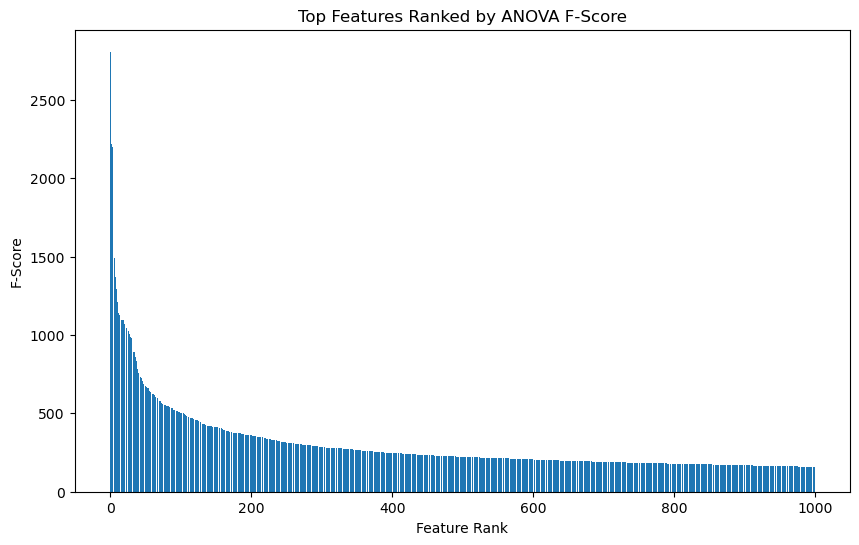

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(range(k), sorted_f_scores[:k])
plt.xlabel('Feature Rank')
plt.ylabel('F-Score')
plt.title('Top Features Ranked by ANOVA F-Score')
plt.show()


**Observations:**

Sharp Drop in F-Scores:
- The plot shows that the first few features have very high F-scores, indicating that they are extremely discriminative.
- F-scores decline rapidly, suggesting that most features have diminishing contributions to class discrimination.

Feature Redundancy:
- After the first few features, the slope becomes more gradual, implying that many features may provide overlapping or redundant information.

In [28]:
from sklearn.model_selection import cross_val_score

N = 25  
X_train_top = X_train[:, sorted_indices[:N]]
X_val_top = X_val[:, sorted_indices[:N]]

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_top, y_train)

scores = cross_val_score(rf_model, X_train_top, y_train, cv=5)
print(f"Cross-Validation Accuracy with top {N} features: {np.mean(scores):.4f}")


Cross-Validation Accuracy with top 25 features: 0.9958


In [29]:
for N in [5, 10, 15, 20, 25, 50, 100]:  
    X_train_subset = X_train[:, sorted_indices[:N]]
    X_val_subset = X_val[:, sorted_indices[:N]]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X_train_subset, y_train)

    scores = cross_val_score(rf_model, X_train_subset, y_train, cv=5)
    print(f"Cross-Validation Accuracy with top {N} features: {np.mean(scores):.4f}")


Cross-Validation Accuracy with top 5 features: 0.7354
Cross-Validation Accuracy with top 10 features: 0.8396
Cross-Validation Accuracy with top 15 features: 0.8896
Cross-Validation Accuracy with top 20 features: 0.9896
Cross-Validation Accuracy with top 25 features: 0.9958
Cross-Validation Accuracy with top 50 features: 0.9958
Cross-Validation Accuracy with top 100 features: 0.9958


In [30]:
from sklearn.feature_selection import f_classif

classes = np.unique(y_train)
class_f_scores = {}  

for cls in classes:
    # Create binary labels: 1 for the current class, 0 for all others
    y_binary = (y_train == cls).astype(int)
    f_scores, p_values = f_classif(X_train, y_binary)
    
    class_f_scores[cls] = {
        'f_scores': f_scores,
        'p_values': p_values
    }

top_n = 10  
for cls in classes:
    print(f"\nTop {top_n} Features for Class {cls}:")
    f_scores = class_f_scores[cls]['f_scores']
    sorted_indices = np.argsort(f_scores)[::-1]
    
    for i in range(top_n):
        print(f"Feature: {feature_names[sorted_indices[i]]}, F-score: {f_scores[sorted_indices[i]]:.2f}")



Top 10 Features for Class BRCA:
Feature: gene_7964, F-score: 2091.37
Feature: gene_17801, F-score: 2033.27
Feature: gene_6876, F-score: 1872.83
Feature: gene_18746, F-score: 1720.71
Feature: gene_9652, F-score: 1459.56
Feature: gene_6530, F-score: 1240.03
Feature: gene_15589, F-score: 1176.37
Feature: gene_6611, F-score: 1169.15
Feature: gene_6748, F-score: 1084.94
Feature: gene_10731, F-score: 1018.15

Top 10 Features for Class COAD:
Feature: gene_3523, F-score: 3087.24
Feature: gene_2037, F-score: 2715.28
Feature: gene_7238, F-score: 1706.60
Feature: gene_7560, F-score: 1435.12
Feature: gene_11449, F-score: 1430.33
Feature: gene_12013, F-score: 1418.82
Feature: gene_5830, F-score: 1383.71
Feature: gene_11652, F-score: 1314.40
Feature: gene_10098, F-score: 1299.02
Feature: gene_7554, F-score: 1220.33

Top 10 Features for Class KIRC:
Feature: gene_219, F-score: 8897.64
Feature: gene_220, F-score: 8834.00
Feature: gene_14114, F-score: 5970.96
Feature: gene_450, F-score: 5943.94
Feature

In [31]:
from sklearn.multiclass import OneVsRestClassifier

# Train one-vs-rest Random Forest
ovr_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
ovr_model.fit(X_train, y_train)

top_n = 10  
for idx, cls in enumerate(classes):
    importances = ovr_model.estimators_[idx].feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    
    print(f"\nTop {top_n} Features for Class {cls}:")
    for i in range(top_n):
        print(f"Feature: {feature_names[sorted_indices[i]]}, Importance: {importances[sorted_indices[i]]:.4f}")



Top 10 Features for Class BRCA:
Feature: gene_15589, Importance: 0.0236
Feature: gene_6594, Importance: 0.0191
Feature: gene_17801, Importance: 0.0190
Feature: gene_10731, Importance: 0.0178
Feature: gene_1750, Importance: 0.0136
Feature: gene_6673, Importance: 0.0132
Feature: gene_6828, Importance: 0.0126
Feature: gene_16372, Importance: 0.0124
Feature: gene_5680, Importance: 0.0119
Feature: gene_6687, Importance: 0.0118

Top 10 Features for Class COAD:
Feature: gene_5829, Importance: 0.0258
Feature: gene_6072, Importance: 0.0227
Feature: gene_14845, Importance: 0.0194
Feature: gene_13355, Importance: 0.0188
Feature: gene_10809, Importance: 0.0181
Feature: gene_4578, Importance: 0.0165
Feature: gene_10412, Importance: 0.0164
Feature: gene_8596, Importance: 0.0161
Feature: gene_12013, Importance: 0.0135
Feature: gene_3489, Importance: 0.0127

Top 10 Features for Class KIRC:
Feature: gene_1510, Importance: 0.0226
Feature: gene_3439, Importance: 0.0200
Feature: gene_450, Importance: 0.0

In [32]:
class_top_features = {}

for cls in classes:
    f_scores = class_f_scores[cls]['f_scores']
    sorted_indices = np.argsort(f_scores)[::-1][:top_n]
    class_top_features[cls] = [feature_names[i] for i in sorted_indices]

print("\nTop Features for Each Class:")
for cls, features in class_top_features.items():
    print(f"Class {cls}: {features}")

for cls in classes:
    other_classes = set(classes) - {cls}
    other_features = set().union(*(class_top_features[c] for c in other_classes))
    unique_features = set(class_top_features[cls]) - other_features
    print(f"\nUnique Features for Class {cls}: {list(unique_features)}")



Top Features for Each Class:
Class BRCA: ['gene_7964', 'gene_17801', 'gene_6876', 'gene_18746', 'gene_9652', 'gene_6530', 'gene_15589', 'gene_6611', 'gene_6748', 'gene_10731']
Class COAD: ['gene_3523', 'gene_2037', 'gene_7238', 'gene_7560', 'gene_11449', 'gene_12013', 'gene_5830', 'gene_11652', 'gene_10098', 'gene_7554']
Class KIRC: ['gene_219', 'gene_220', 'gene_14114', 'gene_450', 'gene_13818', 'gene_16132', 'gene_1510', 'gene_12808', 'gene_16169', 'gene_16246']
Class LUAD: ['gene_15898', 'gene_15895', 'gene_11903', 'gene_15896', 'gene_15591', 'gene_15894', 'gene_15899', 'gene_15161', 'gene_11352', 'gene_13639']
Class PRAD: ['gene_9175', 'gene_9176', 'gene_18135', 'gene_3737', 'gene_9626', 'gene_12995', 'gene_13976', 'gene_16358', 'gene_12848', 'gene_203']

Unique Features for Class BRCA: ['gene_6530', 'gene_15589', 'gene_10731', 'gene_6876', 'gene_17801', 'gene_7964', 'gene_18746', 'gene_9652', 'gene_6748', 'gene_6611']

Unique Features for Class COAD: ['gene_3523', 'gene_7560', 'g

In [81]:
unique_features_by_class = {
    'BRCA': ['gene_6876', 'gene_6611', 'gene_6530', 'gene_9652', 'gene_6748',
             'gene_17801', 'gene_7964', 'gene_15589', 'gene_18746', 'gene_10731'],
    'COAD': ['gene_2037', 'gene_7560', 'gene_3523', 'gene_7238', 'gene_5830',
             'gene_7554', 'gene_11449', 'gene_12013', 'gene_10098', 'gene_11652'],
    'KIRC': ['gene_219', 'gene_1510', 'gene_220', 'gene_12808', 'gene_13818',
             'gene_450', 'gene_16246', 'gene_14114', 'gene_16132', 'gene_16169'],
    'LUAD': ['gene_11903', 'gene_13639', 'gene_15895', 'gene_15898', 'gene_15899',
             'gene_15896', 'gene_15161', 'gene_11352', 'gene_15591', 'gene_15894'],
    'PRAD': ['gene_12995', 'gene_9626', 'gene_3737', 'gene_203', 'gene_13976',
             'gene_9176', 'gene_9175', 'gene_16358', 'gene_12848', 'gene_18135']
}

for class_label, unique_features in unique_features_by_class.items():
    
    class_indices = [feature_names.index(f) for f in unique_features]
    
    X_train_class = X_train[:, class_indices]
    X_test_class = X_test[:, class_indices]
    y_train_class = (y_train == class_label).astype(int)  
    y_test_class = (y_test == class_label).astype(int)  
    
    rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_class.fit(X_train_class, y_train_class)
    
    y_pred_class = rf_class.predict(X_test_class)
    print(f"Accuracy for {class_label} Classification: {accuracy_score(y_test_class, y_pred_class):.4f}")


Accuracy for BRCA Classification: 1.0000
Accuracy for COAD Classification: 1.0000
Accuracy for KIRC Classification: 0.9938
Accuracy for LUAD Classification: 0.9876
Accuracy for PRAD Classification: 1.0000



Generating feature importance plot for class BRCA...


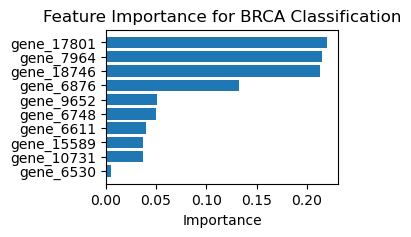


Generating feature importance plot for class COAD...


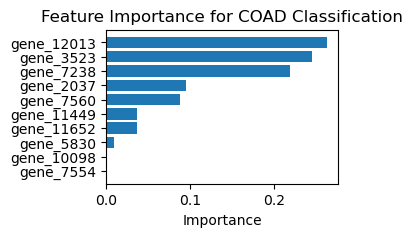


Generating feature importance plot for class KIRC...


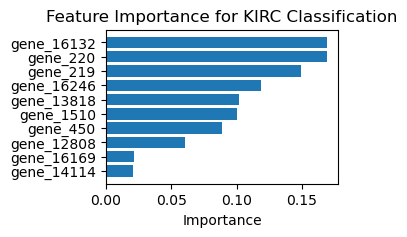


Generating feature importance plot for class LUAD...


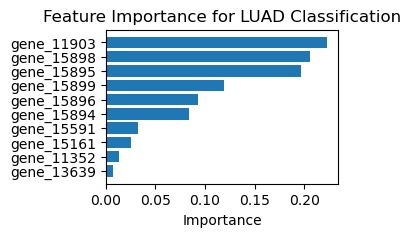


Generating feature importance plot for class PRAD...


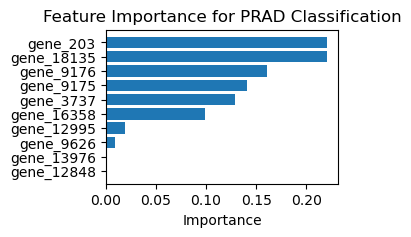

In [80]:
unique_features_by_class = {
    'BRCA': ['gene_6876', 'gene_6611', 'gene_6530', 'gene_9652', 'gene_6748',
             'gene_17801', 'gene_7964', 'gene_15589', 'gene_18746', 'gene_10731'],
    'COAD': ['gene_2037', 'gene_7560', 'gene_3523', 'gene_7238', 'gene_5830',
             'gene_7554', 'gene_11449', 'gene_12013', 'gene_10098', 'gene_11652'],
    'KIRC': ['gene_219', 'gene_1510', 'gene_220', 'gene_12808', 'gene_13818',
             'gene_450', 'gene_16246', 'gene_14114', 'gene_16132', 'gene_16169'],
    'LUAD': ['gene_11903', 'gene_13639', 'gene_15895', 'gene_15898', 'gene_15899',
             'gene_15896', 'gene_15161', 'gene_11352', 'gene_15591', 'gene_15894'],
    'PRAD': ['gene_12995', 'gene_9626', 'gene_3737', 'gene_203', 'gene_13976',
             'gene_9176', 'gene_9175', 'gene_16358', 'gene_12848', 'gene_18135']
}

for class_label, unique_features in unique_features_by_class.items():
    print(f"\nGenerating feature importance plot for class {class_label}...")
    
    class_indices = [feature_names.index(f) for f in unique_features]
    
    X_train_class = X_train[:, class_indices]
    y_train_class = (y_train == class_label).astype(int)  

    rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_class.fit(X_train_class, y_train_class)
    
    importances = rf_class.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(3, 2))
    plt.barh(range(len(unique_features)), importances[sorted_indices], align='center')
    plt.yticks(range(len(unique_features)), [unique_features[i] for i in sorted_indices])
    plt.xlabel("Importance")
    plt.title(f"Feature Importance for {class_label} Classification")
    plt.gca().invert_yaxis()
    plt.show()


In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

unique_features_by_class = {
    'BRCA': ['gene_9652', 'gene_10731', 'gene_17801', 'gene_7964', 'gene_630'],
    'COAD': ['gene_12013', 'gene_3523', 'gene_7238', 'gene_2037'],
    'KIRC': ['gene_219', 'gene_16132', 'gene_220'],
    'LUAD': ['gene_11903', 'gene_15898', 'gene_15895', 'gene_15899'],
    'PRAD': ['gene_203', 'gene_18135', 'gene_9176', 'gene_9175', 'gene_3737']
}

for class_label, unique_features in unique_features_by_class.items():    
    class_indices = [feature_names.index(f) for f in unique_features]
    
    X_train_class = X_train[:, class_indices]
    X_test_class = X_test[:, class_indices]
    y_train_class = (y_train == class_label).astype(int)  
    y_test_class = (y_test == class_label).astype(int)  
    
    rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_class.fit(X_train_class, y_train_class)
    
    y_pred_class = rf_class.predict(X_test_class)
    print(f"Accuracy for {class_label} Classification: {accuracy_score(y_test_class, y_pred_class):.4f}")


Accuracy for BRCA Classification: 1.0000
Accuracy for COAD Classification: 1.0000
Accuracy for KIRC Classification: 0.9876
Accuracy for LUAD Classification: 0.9752
Accuracy for PRAD Classification: 1.0000


In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

genes_to_test = {
    'BRCA': ['gene_9652', 'gene_10731', 'gene_7964'],
    'COAD': ['gene_12013', 'gene_3523', 'gene_7238', 'gene_2037'],
    'KIRC': ['gene_219', 'gene_16132', 'gene_220'],
    'LUAD': ['gene_11903', 'gene_15898', 'gene_15895', 'gene_15899'],
    'PRAD': ['gene_203', 'gene_18135', 'gene_9176', 'gene_9175', 'gene_3737']
}

for class_label, gene_list in genes_to_test.items():
    for gene in gene_list:        
        gene_index = feature_names.index(gene)
        X_train_gene = X_train[:, [gene_index]]  
        X_test_gene = X_test[:, [gene_index]]  
        y_train_class = (y_train == class_label).astype(int)  
        y_test_class = (y_test == class_label).astype(int)  
        
        rf_gene = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_gene.fit(X_train_gene, y_train_class)
        y_pred_gene = rf_gene.predict(X_test_gene)
        
        accuracy = accuracy_score(y_test_class, y_pred_gene)
        print(f"Accuracy for {class_label} Classification with {gene}: {accuracy:.4f}")

Accuracy for BRCA Classification with gene_9652: 0.9255
Accuracy for BRCA Classification with gene_10731: 0.9068
Accuracy for BRCA Classification with gene_7964: 0.9876
Accuracy for COAD Classification with gene_12013: 0.9876
Accuracy for COAD Classification with gene_3523: 1.0000
Accuracy for COAD Classification with gene_7238: 0.9938
Accuracy for COAD Classification with gene_2037: 1.0000
Accuracy for KIRC Classification with gene_219: 0.9876
Accuracy for KIRC Classification with gene_16132: 0.9317
Accuracy for KIRC Classification with gene_220: 0.9876
Accuracy for LUAD Classification with gene_11903: 0.9565
Accuracy for LUAD Classification with gene_15898: 0.9814
Accuracy for LUAD Classification with gene_15895: 0.9752
Accuracy for LUAD Classification with gene_15899: 0.9503
Accuracy for PRAD Classification with gene_203: 0.9938
Accuracy for PRAD Classification with gene_18135: 1.0000
Accuracy for PRAD Classification with gene_9176: 1.0000
Accuracy for PRAD Classification with gene_